# Stick Breaking Construction

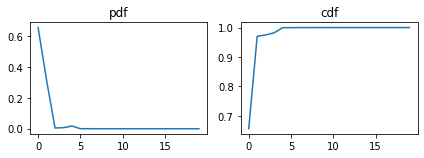

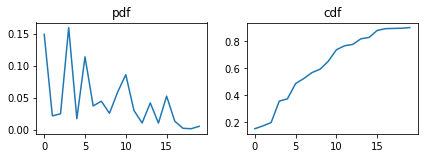

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

"""
    Stick Breaking Construction
"""


# GEM
def GEM(alpha, N=20):
    cnt = 0
    vs = []
    bs = []
    while cnt < N:
        v = np.random.beta(1, alpha)
        b = v
        if len(vs) > 0 :
            for v_ in vs :
                b *= (1 - v_)

        vs.append(v)
        bs.append(b)
        cnt += 1
    return bs

bs = GEM(1)
plt.subplot(2,2,1)
plt.title('pdf')
plt.plot(bs)


plt.subplot(2,2,2)
plt.title('cdf')
plt.plot(np.cumsum(bs))

plt.tight_layout()
plt.show()



bs = GEM(10)
plt.subplot(2,2,3)
plt.title('pdf')
plt.plot(bs)


plt.subplot(2,2,4)
plt.title('cdf')
plt.plot(np.cumsum(bs))

plt.tight_layout()
plt.show()
 

# Polya Urn Scheme

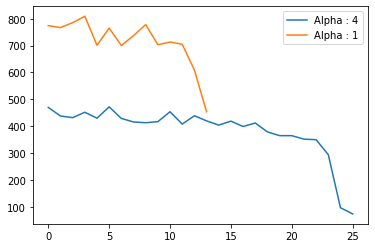

In [ ]:
import random
import matplotlib.pyplot as plt
from collections import Counter
def coin_toss(alpha, n):
    coin = random.random()*(alpha + n - 1)
    return coin < alpha

def polya_urn_scheme(alpha, iterations=10000):
    urn = []
    n = 1
    for _ in range(iterations):
        if coin_toss(alpha, n): # new.
            # base distribution
            urn.append(1)
        else :
            pick_idx = random.randrange(0, len(urn))
            urn[pick_idx] += 1
        n += 1
    return urn


urn = polya_urn_scheme(alpha=4)
plt.plot(urn, label="Alpha : 4")
urn = polya_urn_scheme(alpha=1)
plt.plot(urn, label="Alpha : 1")
plt.legend()


# DPMM (Chinese Restaurant Process, Polya Urn Scheme)
Chinese Restaurant Process는 Dirichlet process를 non parametric 하게 수행하는 것이다.

In [ ]:
from functools import reduce
import random
import copy
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from tqdm.notebook import tqdm

def coin_toss(alpha, n):
    coin = random.random()*(alpha + n - 1)
    return coin < alpha

def polya_urn_scheme(data, alpha, upperlimit):
    urn = []
    cluster_data = []
    n = 1
    
    for i, x in enumerate(data):
        if coin_toss(alpha, n) and len(urn) < upperlimit: # new.
            # base distribution
            urn.append(1)
            cluster_data.append([x])
        else :
            pick_idx = random.randrange(0, len(urn))
            urn[pick_idx] += 1
            cluster_data[pick_idx].append(x)
        n += 1
    return urn, cluster_data

def cum_sum(arg):
    return reduce(lambda a, x: a + [a[-1]+x] if a else [x], arg, [])


class DPMM :
    def __init__(self, data, alpha, upperlimit=100, sampling_iterations=10000):
        self.data = data
        self.upperlimit = upperlimit
        self.alpha = alpha
        self.cluster = []
        self.base_distribution = np.random.normal
        self.sampling_iterations = sampling_iterations

    def init_parameters(self, num):
        params = []
        for n in range(num):
            mu = self.base_distribution(0, 1, 2)
            cov = np.array([[1, 0], [0, 1]])
            params.append([mu, cov])
        return params
        
            
    def init_assignment(self):
        
        cluster_len_info, cluster_data = polya_urn_scheme(self.data, self.alpha, self.upperlimit)
        parameters = self.init_parameters(len(cluster_len_info))
        return cluster_len_info, cluster_data, parameters
    

    def remove_assignment(self, idx, cluster_len_info, cluster_data, parameters): # 총 개수는 len(data)임. -> 여기 수정해야함. idx 인덱싱해서 걸리는 부분.
        cumsum = cum_sum(cluster_len_info)
        for i, cs in enumerate(cumsum) :
            if idx < cs :
                if i == 0 :
                    cluster_len_info[i] -= 1
                    self.now_removed_sample = cluster_data[i][idx-1]
                    cluster_data[i].pop(idx-1) # 삭제.
                else :
                    cluster_len_info[i] -= 1
                    self.now_removed_sample = cluster_data[i][idx-cumsum[i-1]-1]
                    cluster_data[i].pop(idx-cumsum[i-1]-1) # 삭제.
                if cluster_len_info[i] == 0:
                    cluster_len_info.pop(i)
                    cluster_data.pop(i)
                    parameters.pop(i)
                break
            else :
                if i == (len(cumsum)-1):
                    cluster_len_info[i] -= 1
                    self.now_removed_sample = cluster_data[i][-1]
                    cluster_data[i].pop(-1) # 삭제.
                    if cluster_len_info[i] == 0:
                        cluster_len_info.pop(i)
                        cluster_data.pop(i)
                        parameters.pop(i)
        
        return cluster_len_info, cluster_data, parameters

    def prior(self, cluster_len_info):
        n = len(self.data)
        priors = [] 
        for event in cluster_len_info:
            priors.append(event/(self.alpha+sum(cluster_len_info))) # 하나가 빠져있을거라서 -1 안해도 됌. 각 cluster의 수 고려.
        priors.append(self.alpha/(self.alpha+sum(cluster_len_info))) # 새로운 테이블.
        return priors

    def likelihood(self, cluster_len_info, cluster_data, params): 
        likelihoods = [] # 각 클러스터에 대해
        params_ = copy.deepcopy(params)
        params_.append([self.base_distribution(0, 1, 2), [[1,0],[0,1]]])
        for i in range(len(cluster_len_info)):
            mu, cov = params_[i]
            likelihoods.append(multivariate_normal.pdf(self.now_removed_sample, mean=mu, cov=cov, allow_singular=True))
        mu, cov = params_[-1]
        likelihoods.append(multivariate_normal.pdf(self.now_removed_sample, mean=mu, cov=cov, allow_singular=True))
        return likelihoods
        

    def posterior_approx(self, priors, likelihoods):
        posteriors = []
        for p, l in zip(priors, likelihoods):
            posteriors.append(p*l)

        return posteriors
    
    def cluster_assignment(self, posteriors, cluster_len_info, cluster_data, parameters):
        idx = np.argmax(posteriors)
        if idx >= len(cluster_len_info):
            cluster_len_info.append([1])
            cluster_data.append([self.now_removed_sample])
            parameters.append([self.base_distribution(0, 1, 2), [[1,0],[0,1]]])

        else :
            cluster_len_info[idx] += 1
            cluster_data[idx].append(self.now_removed_sample)
        
        return cluster_len_info, cluster_data, parameters


    # def mle(self, cd): -> Positive Semidefinite 문제 발생.
    #     def estimation(obs,fun,init,method='Nelder-Mead'):
    #         mle = lambda param: -np.sum(fun(*[obs,param])) ## negate since we will minimize
    #         result = minimize(mle,init,method=method)
    #         return result.x
    #     ini_m = [0,0,1,2,2,1]
    #     params = estimation(cd,lambda ob,p :multivariate_normal.logpdf(ob,[p[0],p[1]],[[p[2],p[3]],[p[4],p[5]]]),ini_m) # 오류뜸..
    #     mu = np.array(params[:2])
    #     cov = np.array([params[2:4].tolist(),params[4:].tolist()]) # 4개.
    #     print(cov, mu)
    #     return mu, cov


    def mle(self,cd): # cd : N by 2 2 by N * N by 2
        mu = cd.mean(axis=0)                                                                                                                                                                            
        cov = (cd-mu).T @ (cd-mu) / cd.shape[0] #  this is slightly suboptimal, but instructive
        return mu, cov                                                                                                                                                                                    


    def dpmm(self):

        cluster_len_info, cluster_data, parameters = self.init_assignment()
        for _ in tqdm(range(self.sampling_iterations)):
            indices = list(range(1, len(self.data)+1)) # 1부터로 설정햇음.
            random.shuffle(indices)
            for idx in indices : # 1부터임을 감안.
                cluster_len_info, cluster_data, parameters = self.remove_assignment(idx, cluster_len_info, cluster_data, parameters)
                priors = self.prior(cluster_len_info)
                likelihoods = self.likelihood(cluster_len_info, cluster_data, parameters)
                posteriors = self.posterior_approx(priors, likelihoods)
                cluster_len_info, cluster_data, parameters = self.cluster_assignment(posteriors, cluster_len_info, cluster_data, parameters)
                
                for i, cd in enumerate(cluster_data) : # 각 그룹에 대해 mle
                    mu, cov = self.mle(np.array(cd))
                    parameters[i][0] = mu
                    parameters[i][1] = cov

        return cluster_len_info, cluster_data, parameters

    def __len__(self):
        return len(self.data)
    
    


if __name__=='__main__':
    def make_samples(): # sampling 함수 정하기.

        cov = np.array([[1, -2], [-2, 0.5]])
        pts1 = np.random.multivariate_normal([0, 0], cov, size=300) # 200개 뽑고
        cov = np.array([[2, 1.5], [1.5, 1.5]])
        pts2 = np.random.multivariate_normal([2, 3], cov, size=700) # 400개 뽑자

        datas = np.vstack([pts1, pts2])
        return datas
    
    # 원래 이렇게 느린가?
    data = make_samples()
    dpmm = DPMM(data, alpha=1, upperlimit=15, sampling_iterations=1000)
    cluster_len_info, cluster_data, parameters = dpmm.dpmm()
    print(cluster_len_info, cluster_data, parameters)

In [ ]:
print(f"Cluster Length Information : {cluster_len_info} \n \n")
print(f"Cluster Datas : {cluster_data} \n \n")
print(f"Cluster Parameter Information : {parameters} \n \n")



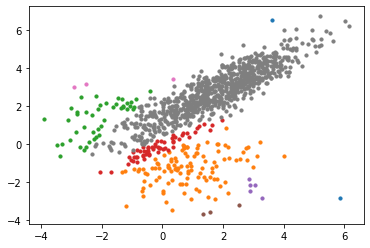

In [ ]:
import matplotlib.pyplot as plt

# visualization
def visualize(cluster_data):
    # assigned_datas
    results = []
    for now_datas in cluster_data:
        xs = [x for x, _ in now_datas]
        ys = [y for _, y in now_datas]
        results.append([xs, ys])

    for i in range(len(cluster_data)):
        xs, ys = results[i]
        plt.scatter(xs, ys, s=10)





visualize(cluster_data)
# 중간에서 끊는 부분이 있어서 이렇게 mixture model이 형성된다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


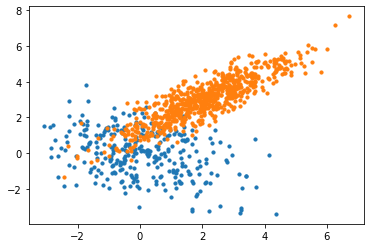

In [ ]:
cov = np.array([[1, -2], [-2, 0.5]])
pts1 = np.random.multivariate_normal([0, 0], cov, size=300) # 300개 뽑고
cov = np.array([[2, 1.5], [1.5, 1.5]])
pts2 = np.random.multivariate_normal([2, 3], cov, size=700) # 700개 뽑자


xs = [x for x, _ in pts1]
ys = [y for _, y in pts1]
plt.scatter(xs, ys, s=10)

xs = [x for x, _ in pts2]
ys = [y for _, y in pts2]
plt.scatter(xs, ys, s=10)
